In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
from tqdm import tqdm_notebook as tqdm
from torch import optim
import pandas as pd
import time
from torchvision import transforms, datasets
import torch.nn.functional as F
import os
from os import listdir
from os.path import isfile, join

# Arquitectura

In [20]:
class ExpandedCnnLSTM(nn.Module):
  
  def __init__(self, resnet_model, n_channels, output_size, hidden_dim, n_lstm_layers, drop_prob=0.5, debug=False):

    super(ExpandedCnnLSTM, self).__init__()

    self.output_size = output_size
    self.n_lstm_layers = n_lstm_layers
    self.hidden_dim = hidden_dim
    self.n_channels = n_channels
          
    model = torch.hub.load('pytorch/vision:v0.6.0', resnet_model, pretrained=True)
    out_channels = model.conv1.in_channels
    kernel_size = model.conv1.kernel_size
    stride = model.conv1.stride
    padding = model.conv1.padding
    self.convPadd = nn.Conv2d(n_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
    
    self.embeding_dim = model.fc.in_features
    self.cnn = torch.nn.Sequential(*(list(model.children())[:-1]))
    if debug:
      print(model.eval())
      print(self.cnn[0].in_channels)
    

    self.lstm = nn.LSTM(self.embeding_dim, hidden_dim, n_lstm_layers, dropout=drop_prob, batch_first=True)
    self.dropout = nn.Dropout(drop_prob)
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    batch_size = x.size(0)
    n_frames = x.size(1)

    features = torch.zeros((batch_size, n_frames, self.embeding_dim))

    for i in range(n_frames):
      padded = self.convPadd(x[:,i,:])
      features[:,i,:] = self.cnn(padded).squeeze()

    lstm_out, hidden = self.lstm(features.to(device))
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
    out = self.dropout(lstm_out)
    out = self.fc(out)
    out = self.sigmoid(out)
    
    out = out.view(batch_size, -1)
    out = out[:,-1]
    
    return out

  def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_lstm_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_lstm_layers, batch_size, self.hidden_dim).zero_())
        return hidden

In [21]:
#cl_model = CnnLSTM(4, 1, 512, 2)
cl_model = ExpandedCnnLSTM('resnet18', 4, 1, 512, 2, debug=True)

Using cache found in /home/jupyter/.cache/torch/hub/pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
positive_path = '/home/jupyter/data-step/processed_data/positive/dataset/'
negative_path = '/home/jupyter/data-step/processed_data/negative/dataset/'

In [ ]:
positive_files = [positive_path + f for f in listdir(positive_path)]
y_p = np.ones((len(positive_files)))
print(len(positive_files))

negative_files = [negative_path + f for f in listdir(negative_path)]
y_n = np.zeros((len(negative_files)))
print(len(negative_files))

In [7]:
total_files = positive_files + negative_files

y_tot = np.append(y_p, y_n)

print(len(total_files), y_tot.shape)

87 (87,)


In [ ]:
positive_path_lite = '/home/jupyter/data-step-lite/processed_data/positive/dataset/'
negative_path_lite = '/home/jupyter/data-step-lite/processed_data/negative/dataset/'

In [ ]:
def torch_divider(tensor_, save_path, div=160//32):
    tensor_samples = torch.split(tensor_, div)
    for i, t in enumerate(tensor_samples):
        torch.save(t, save_path + '_' + str(i) + ".pt")
        
for sat in listdir(positive_path):
    path = positive_lite + sat + '/'
    for file in listdir(path):
        t = torch.load(path + file)
        save_path = positive_path_lite + sat + '/' + file
        torch_divider(t, save_path)


In [ ]:
def channel_metrics(data):
    n_channels = len(data[0,0, :])
    #print("num channels: ", n_channels)
    means = []
    stds = []

    for i in range(n_channels):
            means.append(np.mean(data[:, :, i, :, :]))
            stds.append(np.std(data[:, :, i, :, :]))
    print(means, stds)
    return means, stds




def total_metrics(files):
    means = []
    stds = []
    count = 0
    
    for f in tqdm(files):
        #print(count, end='\r')
        data = torch.load(f)
        #print(data.shape)
        mean, std = channel_metrics(data.numpy())
        means.append(mean)
        stds.append(std)
        count += 1
        
    return means, stds
        
means, stds = total_metrics(total_files)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [9]:
#torch.load(total_files[0])[0]

In [11]:
means_np = np.array(means)
print(means_np.shape)

stds_np = np.array(stds)
print(stds_np.shape)

(87, 16)
(87, 16)


In [18]:
norm_means = np.mean(means_np, axis=0)
norm_stds = np.sqrt(np.sum((np.array(stds_np)**2), axis=0))/len(total_files)

print(norm_means.shape, norm_stds.shape)
print(norm_means, norm_stds)
np.save("/home/jupyter/means.npy", norm_means)
np.save("/home/jupyter/stds.npy", norm_stds)
#stds_np

(16,) (16,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
class LandslideDataset(Dataset):
  
    def __init__(self, dirs, y):

        self.dirs = sorted(dirs) 
        self.y = y

    def __len__(self): 
        return len(self.dirs)*160   # REVISAR ESTO

    def __getitem__(self, idx):

        return torch.load(self.dirs[int(idx/160)])[idx%160], self.y[int(idx/160)]

In [8]:
#total_ds = LandslideDataset(total_files, y_tot)
random.shuffle(positive_files)
random.shuffle(negative_files)

print(positive_files[0])

pos_cut = int(0.9*len(positive_files))
neg_cut = int(0.9*len(negative_files))

train_files = positive_files[:pos_cut] + negative_files[:neg_cut]
train_labels = np.append(np.ones(pos_cut), np.zeros(neg_cut)
                         
val_files = positive_files[pos_cut:] + negative_files[neg_cut:]
val_labels = np.append(np.ones(len(positive_files) - pos_cut), np.zeros(len(negative_files) - neg_cut))

# Datasets
                         
train_ds = LandslideDataset(train_files, train_labels)
val_ds = LandslideDataset(val_files, val_labels)

In [ ]:
# Dataloaders

train_dl = torch.utils.DataLoader(train_ds, num_workers=16)
val_dl = torch.utils.DataLoader(val_ds, num_workers=16)

In [9]:
total_ds[0][0].shape

torch.Size([9, 16, 224, 224])

In [15]:
train_ds = LanslideDataset(train_dummy_data, train_dummy_labels)
val_ds = LanslideDataset(val_dummy_data, val_dummy_labels)

In [13]:
print('GPU disponible:' , torch.cuda.is_available())
if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")

GPU disponible: True
Let's use 8 GPUs!


In [ ]:
class TrainModule():
  
  def __init__(self, model, opt, loss_func, save_path = ""):
    #self.params = params
    self.model = model
    self.opt = opt
    self.loss_func = loss_func

    self.fig = plt.figure(figsize=(15, 7))
    self.ax0 = self.fig.add_subplot(1, 2, 1) 
    self.ax1 = self.fig.add_subplot(1, 2, 2)
    
    self.save_path = save_path

    self.save_period = 100

    self.visualize_period = 5

  def get_data(self, train_ds, valid_ds, bs, n_cores):

    self.bs = bs

    self.train_dl =  DataLoader(train_ds,
                          batch_size=bs,
                          shuffle=True,
                          num_workers=n_cores)
        
    self.val_dl =  DataLoader(valid_ds,
                          batch_size=bs * 2,
                          num_workers=n_cores)
    
  def set_optimizer(self, opt):
    self.opt = opt

  def set_loss_func(self, loss_func):
    self.loss_func = loss_func
  
  def loss_batch(self, model, loss_func, xb, yb, opt=None):
    y_hat = model(xb)
    loss = loss_func(y_hat, yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #accu = self.accuracy(y_hat, yb)

    return loss.item(), len(xb) #, accu

  def accuracy(self, y_hat_b,yb):
    
    preds = torch.argmax(torch.softmax(y_hat_b.view(-1), dim = 1),dim=1)
    counts = (preds == yb)*1.0
    
    return torch.mean(counts)

  def bin_accuracy(self, y_hat_b,yb):
    
    count = (yb == (y_hat_b > 0.5))*1.0
    return torch.mean(count)

  def register(self, res_list):
    
    losses, nums = zip(*res_list)
    
    N = np.sum(nums)
    loss_mean = np.sum(np.multiply(losses, nums))/N
    loss_std = np.sqrt(np.sum(np.multiply((losses-loss_mean)**2, nums))/(N-1))
    
    return loss_mean, loss_std

  #def early_stoping(self, learning_data):

  def plot_curves(self, loss_data, metric_data, epoch):
      yt = loss_data['train_mean']
      yv = loss_data['val_mean']
      x = np.arange(0, len(yt), 1)
      self.ax0.cla()
      self.ax0.plot(x, yt, label='train loss')
      self.ax0.plot(x, yv, label='val loss')
      self.ax0.legend(loc="upper right")
      self.ax0.set_title("Loss at epoch: {}".format(epoch))

      ytm = metric_data['train_mean']
      yvm = metric_data['val_mean']
      xm = np.arange(0, len(yt), 1)
      self.ax1.cla()
      self.ax1.plot(xm, ytm, label='train accu')
      self.ax1.plot(xm, yvm, label='val accu')
      self.ax1.legend(loc="lower right")
      self.ax1.set_title("Accuracy at epoch: {}".format(epoch))

      display(self.fig)
      
      clear_output(wait = True)
    
  def load_learning_data(self, learning_data):

    self.learning_data = learning_data

  def save_checkpoint(self, model, optimizer, loss_data, metric_data,  epoch):

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            'loss_data': loss_data,
            'metric_data': metric_data
            }, self.save_path + "checkpoint_" + str(epoch))
    
  def load_model(self, model, path):

    model = torch.load(path)

    return model
    
  def save_best_model(self, model, optimizer, loss_data, metric_data, epoch):

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            'loss_data': loss_data,
            'metric_data': metric_data
            }, self.save_path + "best_model")
    
  def load_checkpoint(self, path):

      checkpoint = torch.load(path)
      self.model.load_state_dict(checkpoint['model_state_dict'])
      self.opt.load_state_dict(checkpoint['optimizer_state_dict'])
      epoch = checkpoint['epoch']
      loss_data = checkpoint['loss_data']
      metric_data = checkpoint['metric_data']

      self.loss_data = loss_data
      self.metric_data = metric_data

      return epoch, loss_data, metric_data


  def fit(self, 
        epochs,
        metric=None,
        only_print=True,
        print_leap = 1):
    
    print('GPU disponible:' , torch.cuda.is_available())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using ", device)

    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        self.model = nn.DataParallel(self.model)

    self.model.to(device)
    self.model = self.model.float()

    print("Is model using cuda: ", next(self.model.parameters()).device)

    if metric is None:
        #metric = self.accuracy
        metric= self.bin_accuracy
        #metric = self.loss_func

    loss_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
    
    metric_data = pd.DataFrame(
        columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
    
    best_val_loss = np.inf

    for epoch in tqdm(range(epochs)):

        # Entrenamiento -------------------------------------------------------
        train_res = []
        train_metric = []
        self.model.train()
        for xb, yb in self.train_dl:
            # Actualizacion de parametros
            xb, yb = xb.to(device), yb.to(device)
            self.opt.zero_grad()
            self.loss_batch(self.model, self.loss_func, xb.float(), yb.float(), self.opt)

            # Evaluacion en entrenamiento
            with torch.no_grad():
              train_res.append(self.loss_batch(self.model, self.loss_func, xb.float(), yb.float()))
              train_metric.append(self.loss_batch(self.model, metric, xb.float(), yb.float()))

        # Validacion ----------------------------------------------------------
        # Para evaluar se puede utilizar un metrica de rendimiento
        self.model.eval()

        with torch.no_grad():
            val_res = [
                self.loss_batch(self.model, self.loss_func, xb.to(device).float(), yb.to(device).float()) for xb, yb in self.val_dl]
            val_metric = [
                self.loss_batch(self.model, metric, xb.to(device).float(), yb.to(device).float()) for xb, yb in self.val_dl]

        
        val_loss0, val_std0 = self.register(val_res)
        tra_loss0, train_std0 = self.register(train_res)
        
        
        #if epoch % print_leap == 0:
        #    print('Epoca:', epoch, '- val:', val_loss, '- train:', tra_loss)

        loss_data = loss_data.append(
            {
                'epoch': epoch,
                'train_mean': tra_loss0,
                'train_std': train_std0,
                'val_mean': val_loss0,
                'val_std': val_std0
            },
            ignore_index=True)
        
        val_loss1, val_std1 = self.register(val_metric)
        tra_loss1, train_std1 = self.register(train_metric)
        
        metric_data = metric_data.append(
            {
                'epoch': epoch,
                'train_mean': tra_loss1,
                'train_std': train_std1,
                'val_mean': val_loss1,
                'val_std': val_std1
            },
            ignore_index=True)
        

        if (epoch + 1) % self.save_period == 0:
            #print("saving checkpoint at epoch ", epoch)
            self.save_checkpoint(self.model, self.opt, loss_data, metric_data, epoch)

        if epoch > epochs/10 and val_loss0 < best_val_loss:
            #print("saving best model at epoch ", epoch)
            self.save_best_model(self.model, self.opt, loss_data, metric_data, epoch)

        if epoch % self.visualize_period  == 0:
            self.plot_curves(loss_data, metric_data, epoch)

    if only_print:
        print('Proceso terminado')
        self.loss_data = loss_data
        self.metric_data = metric_data
    else:
        return loss_data, metric_data


In [ ]:
cl_model = ExpandedCnnLSTM('resnet18', 4, 1, 512, 2, debug=False)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Proceso terminado


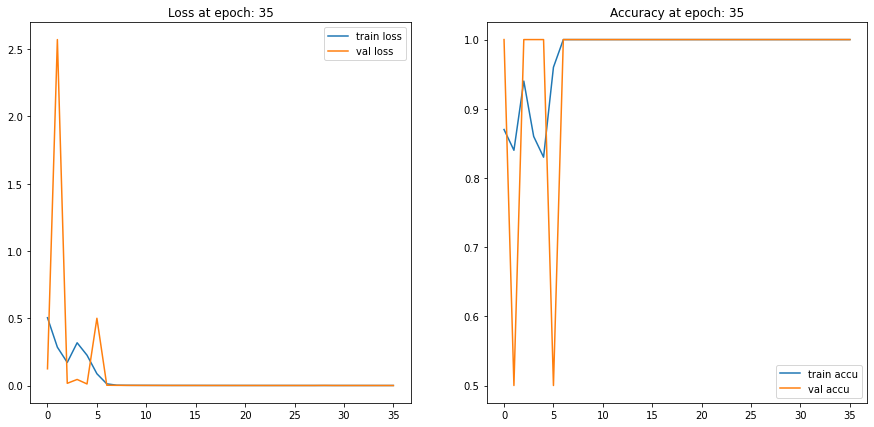

In [ ]:
opt = optim.Adam(cl_model.parameters())

loss_func = torch.nn.BCELoss()

TM = TrainModule(cl_model, opt, loss_func)

TM.get_data(train_ds, val_ds, 3, 0)

TM.fit(40)

In [ ]:
TM.load_checkpoint("/content/best_model")

TM.loss_data

,epoch,train_mean,train_std,val_mean,val_std
0,0.0,0.503561,1.038491,0.124135,0.091710
1,1.0,0.284618,0.351057,2.569973,2.252450
2,2.0,0.171327,0.341561,0.016361,0.011023
3,3.0,0.317469,0.756883,0.045008,0.035788
4,4.0,0.225052,0.311097,0.011560,0.008533
5,5.0,0.087506,0.214187,0.499567,0.437961
6,6.0,0.012449,0.035111,0.002109,0.001348
7,7.0,0.002393,0.001265,0.001342,0.000849
8,8.0,0.001433,0.000630,0.001038,0.000640
9,9.0,0.001159,0.000554,0.000874,0.000546
